# Recomendation System using AutoEncoder and Pytorch

## Importing Library 

In [1]:
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import warnings

warnings.filterwarnings('ignore')

## Importing Dataset

### 1. Movie Data

In [2]:

movies = pd.read_csv('ml-1m/movies.dat',
                     sep= '::',
                     header = None,
                     engine = 'python',
                     encoding = 'latin-1'
                     )
print(movies.head(10))
print("\nShape of Movies set ", movies.shape)

    0                                   1                             2
0   1                    Toy Story (1995)   Animation|Children's|Comedy
1   2                      Jumanji (1995)  Adventure|Children's|Fantasy
2   3             Grumpier Old Men (1995)                Comedy|Romance
3   4            Waiting to Exhale (1995)                  Comedy|Drama
4   5  Father of the Bride Part II (1995)                        Comedy
5   6                         Heat (1995)         Action|Crime|Thriller
6   7                      Sabrina (1995)                Comedy|Romance
7   8                 Tom and Huck (1995)          Adventure|Children's
8   9                 Sudden Death (1995)                        Action
9  10                    GoldenEye (1995)     Action|Adventure|Thriller

Shape of Movies set  (3883, 3)


### 2. User Dataset

In [3]:

user = pd.read_csv('ml-1m/users.dat',
                     sep= '::',
                     header = None,
                     engine = 'python',
                     encoding = 'latin-1'
                     )

print(user.head(10))
print("\nShape of user set ", user.shape)

    0  1   2   3      4
0   1  F   1  10  48067
1   2  M  56  16  70072
2   3  M  25  15  55117
3   4  M  45   7  02460
4   5  M  25  20  55455
5   6  F  50   9  55117
6   7  M  35   1  06810
7   8  M  25  12  11413
8   9  M  25  17  61614
9  10  F  35   1  95370

Shape of user set  (6040, 5)


### 3. Rating Dataset

In [4]:

rating = pd.read_csv('ml-1m/ratings.dat',
                     sep= '::',
                     header = None,
                     engine = 'python',
                     encoding = 'latin-1'
                     )

print(rating.head(10))
print("\nShape of rating set ", rating.shape)

   0     1  2          3
0  1  1193  5  978300760
1  1   661  3  978302109
2  1   914  3  978301968
3  1  3408  4  978300275
4  1  2355  5  978824291
5  1  1197  3  978302268
6  1  1287  5  978302039
7  1  2804  5  978300719
8  1   594  4  978302268
9  1   919  4  978301368

Shape of rating set  (1000209, 4)


## Preparing Training and Test set

In [6]:
training_set = pd.read_csv('ml-100k/u2.base', delimiter='\t')

# converting to array
training_set = np.array(training_set, dtype = int)
print("Shape of Training Set :", training_set.shape)

Shape of Training Set : (79999, 4)


In [7]:
test_set = pd.read_csv('ml-100k/u2.test', delimiter='\t')

# converting to array
test_set = np.array(test_set, dtype = int)
print("Shape of Test Set :", test_set.shape)

Shape of Test Set : (19999, 4)


## Creating the number of user and movies

In [8]:
nb_users = int(max(max(training_set[:,0]), max(test_set[:,0])))
print(nb_users)

nb_movies = int(max(max(training_set[:,1]), max(test_set[:,1])))
print(nb_movies)

943
1682


## Converting the data into an array with users in line and movies in columns

In [9]:
def convert(data):
    new_data = []
    for id_users in range(1, nb_users + 1):
        id_movies = data[:,1][data[:,0]==id_users]
        id_rating = data[:, 2][data[:, 0] == id_users]
        rating = np.zeros(nb_movies)
        rating[id_movies-1] = id_rating
        new_data.append(list(rating))
    return new_data

training_set = convert(training_set)
test_set = convert(test_set)
        

## Converting the data into Torch tensor

In [10]:
training_set = torch.FloatTensor(training_set)
test_set = torch.FloatTensor(test_set)

## Creating architecture of the NN

In [11]:
class SAE (nn.Module):
    def __init__(self):
        super(SAE, self).__init__()
        self.fc1 = nn.Linear(nb_movies, 20)
        self.fc2 = nn.Linear(20, 10)
        self.fc3 = nn.Linear(10, 20)
        self.fc4 = nn.Linear(20, nb_movies)
        self.activation = nn.Sigmoid()
        
    def forward(self, x ):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x
    
    def predict( self, x):
        return self.forward(x)


In [12]:
sae = SAE()

criterion = nn.MSELoss()
optimiser = optim.RMSprop(sae.parameters(), lr = 0.01 , weight_decay = 0.05)


## Training the Auto Encoders

In [13]:
nb_epoch = 200
for epoch in range(1, nb_epoch+1):
    train_loss = 0 
    s = 0. # counter
    for id_user in range(nb_users):
        # Make it a batch of input vectors (reshape in keras )
        input = Variable(torch.FloatTensor(training_set[id_user])).unsqueeze(0)
        target = input.clone()
        if torch.sum(target.data > 0 ) > 0 :
            output = sae.forward(input)
            target.required_grad = False   # Reducing computation by not performing Gradient Descent on target variable
            output[target == 0 ] = 0  # No Weights update for Movies without rating
            loss = criterion(output, target)  # Loss variable for predicted and actual ratings
            loss.backward()  # Helps to find the direction of weight updation ( + or - ) during back propagation
            mean_corrector = nb_movies/ float( torch.sum(target.data > 0) + 1e-10 ) # find the mean for the movies given rating . Added 1e-10 to eliminate scenarios of infinite computation
            optimiser.step()  # decides the magnitude of weight updation during back propagation 
            train_loss += np.sqrt(loss.data.item()* mean_corrector)
            s += 1.
    print(f'epoch: {epoch} loss: {train_loss/s}')
            
    

epoch: 1 loss: 1.2293340938615973
epoch: 2 loss: 1.1017855710596505
epoch: 3 loss: 1.0721662481368595
epoch: 4 loss: 1.0606781639739096
epoch: 5 loss: 1.0537416484485642
epoch: 6 loss: 1.049706835224713
epoch: 7 loss: 1.0465202582089286
epoch: 8 loss: 1.038859802974925
epoch: 9 loss: 1.0361730556703714
epoch: 10 loss: 1.0307048675462784
epoch: 11 loss: 1.0271148024870684
epoch: 12 loss: 1.0247056100160532
epoch: 13 loss: 1.0222927475698718
epoch: 14 loss: 1.0142294019426505
epoch: 15 loss: 1.0106265750376782
epoch: 16 loss: 1.0135807947864979
epoch: 17 loss: 1.0093992549375348
epoch: 18 loss: 1.006880538787538
epoch: 19 loss: 1.0030172033036275
epoch: 20 loss: 0.9986329774491151
epoch: 21 loss: 0.9942306648493586
epoch: 22 loss: 0.9899248476085165
epoch: 23 loss: 0.9870017747019566
epoch: 24 loss: 0.986821715923769
epoch: 25 loss: 0.9902809585895859
epoch: 26 loss: 0.9862318911666516
epoch: 27 loss: 0.979666624183297
epoch: 28 loss: 0.9762574789309428
epoch: 29 loss: 0.9726347096434301

# Predicting for the test set loss

In [14]:
test_loss = 0 
s = 0. # counter
for id_user in range(nb_users):
    # Make it a batch of input vectors (reshape in keras )
    input = Variable(torch.FloatTensor(training_set[id_user])).unsqueeze(0)
    target = Variable(torch.FloatTensor(test_set[id_user])).unsqueeze(0)
    if torch.sum(target.data > 0 ) > 0 :
        output = sae.forward(input)
#         target.required_grad = False   # Reducing computation by not performing Gradient Descent on target variable
        output[target == 0 ] = 0  # No Weights update for Movies without rating
        loss = criterion(output, target)  # Loss variable for predicted and actual ratings
        mean_corrector = nb_movies/ float( torch.sum(target.data > 0) + 1e-10 ) # find the mean for the movies given rating . Added 1e-10 to eliminate scenarios of infinite computation
        test_loss += np.sqrt(loss.data.item()* mean_corrector)
        s += 1.
        
print(f' Test loss: {test_loss/s}')


 Test loss: 1.0356580659011714


# Saving the model

In [15]:
import time
if 1 == 2 :
    torch.save(sae, f'AutoEncoder_{int(time.time())}.pkl') # you can use one of the function to save the training model


## Prediction Block for the recommending movie to user

In [16]:
sae = torch.load('AutoEncoder_1562564762.pkl')
from operator import itemgetter

def prediction (user_id , nb_recommendation = 10 ):
    input_user = Variable(torch.FloatTensor(test_set[user_id - 1])).unsqueeze(0)
    predict_output = sae.predict(input_user)
    predict_output = np.array(predict_output.data.numpy())
    prediction_result = np.row_stack([input_user, predict_output])
    
    movie_index = np.array([i for i in range(1, nb_movies + 1)]) #Temporary movie index container 
    recommend = np.row_stack([np.array(prediction_result),movie_index]) #Stacking the list for the prediction_result
    recommend = recommend.T.tolist() 
    
    # Fetching the movies for the user which is not viewed and can be used for the recomendation
    movies_not_viewed = []
    for i in range(0, len(recommend)):
        if recommend[i][0]==0:
            movies_not_viewed.append(recommend[i])

    movies_not_viewed = sorted(movies_not_viewed , key=itemgetter(1), reverse=True)
    
    # Indexes for non Viewed movies
    recommend_movie_index = []
    for i in range(nb_recommend):
        recommend_movie_index.append(movies_not_viewed[i][2])
        
    # Fetching Names for the top recommended movies
    recommend_movie_names = []
    for i in recommend_movie_index:
        name = movies[movies.iloc[:,0] == int(i)].values.tolist()[0]
        recommend_movie_names.append(name)

    return recommend_movie_names


## Recommendations 

In [31]:
input_user = 578
nb_recommend = 20

movie_names = prediction(input_user, nb_recommend)

print(f"Top {nb_recommend} movies recommendation for User {input_user} :\n")

cnt=1
print("{:>10} {:>8} {:>50} {:>30}".format('Rec.ID','Movie_id', 'Movie_Name', 'Features'))
for i in movie_names:
    print("{:>10} {:>8} {:>50} {:>30}".format(cnt,i[0], i[1], i[2]))
    cnt += 1

Top 20 movies recommendation for User 578 :

    Rec.ID Movie_id                                         Movie_Name                       Features
         1     1426                            Zeus and Roxanne (1997)                     Children's
         2      814                          Boy Called Hate, A (1995)                          Drama
         3     1467                               Salut cousin! (1996)                   Comedy|Drama
         4     1377                              Batman Returns (1992)  Action|Adventure|Comedy|Crime
         5      868                          Death in Brunswick (1991)                         Comedy
         6     1500                         Grosse Pointe Blank (1997)                   Comedy|Crime
         7     1629                             MatchMaker, The (1997)                 Comedy|Romance
         8     1628                                Locusts, The (1997)                          Drama
         9     1398                  

## Movies User already watched and rated 5 star

In [32]:
rating_user = rating[(rating[2] == 5) & (rating[0]== input_user)][[0,1,2]]
rating_user.rename(columns = {0 : 'user_id', 1: 'movie_id' , 2: 'ratings'}, inplace = True)
movie_user = movies.rename(columns = {0 : 'movie_id', 1: 'movie_name' , 2: 'features'})

movie_user_watched_5_star = pd.merge(rating_user,movie_user[['movie_name','features']],left_on=rating_user['movie_id'], right_on=movie_user['movie_id'])
movie_user_watched_5_star.drop(['key_0'], axis=1, inplace=True)
movie_user_watched_5_star_array =np.array(movie_user_watched_5_star)



## Word Cloud Movie Features

In [33]:
from wordcloud  import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

def wordcloud_draw(data, color = 'black'):
    words = ' '.join(data)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

## Wordcloud for Movie Watched by user

Watched Movies Features 
 ********* 
 


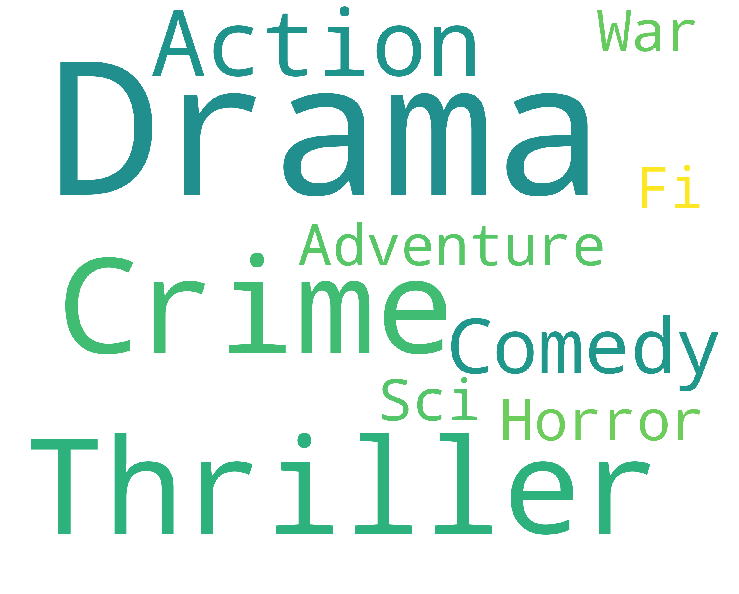

In [36]:
target_features = []
# print(movie_user_watched_5_star_array[4])

for movie_name in movie_user_watched_5_star_array :
    
    if movie_name[4].find("|") != -1:
        for feature in movie_name[4].split('|'):
            target_features.append(feature)
            
    else:
        target_features.append(movie_name[4])
target_features

print("Watched Movies Features \n ********* \n ")
wordcloud_draw(target_features,'white')

## Wordcloud for Movie Predicted for User

Recommended Movies Features  
 ********* 
 


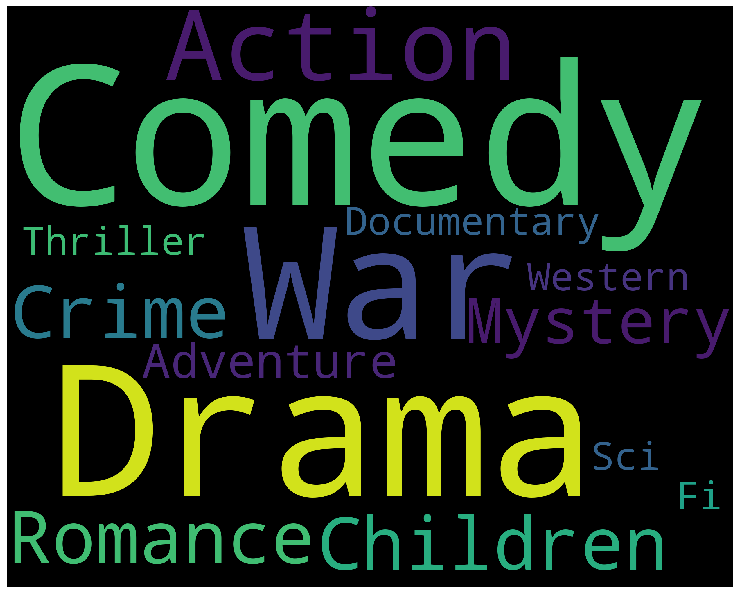

In [38]:
pred_features = []

for movie_name in movie_names :
    
    if movie_name[2].find("|") != -1:
        for feature in movie_name[2].split('|'):
            pred_features.append(feature)
            
    else:
        pred_features.append(movie_name[2])
pred_features
        

print("Recommended Movies Features  \n ********* \n ")
wordcloud_draw(pred_features,'black')

# Conclusion :


Word Cloud shows clearly that movie recommended to User hasd almost same features to the movie user rated 5 star and it is likely that he/she will likely to watch the recommended movies